# Installing and Importing Packages



In [1]:
!pip install swig
!pip install wrds
!pip install pyportfolioopt

!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached swig-4.1.1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.8 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyportfolioopt-1.5.4-py3-none-any.whl (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.6 MB/s eta 0:00:00
✨🍰✨ Everything looks OK!
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.c

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools
import time

/usr/local/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



# Importing Training Data and Setting up Training Environment

In [4]:
train = pd.read_csv('train_data.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']

In [5]:
train.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
,,,,,,,,,,,,,,,,,,
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.758536,746015200.0,4.0,0.0,2.98139,2.652102,100.0,66.666667,100.0,2.758536,2.758536,39.189999,0.0
0,2009-01-02,AMGN,58.590000,59.080002,57.750000,44.219181,6547900.0,4.0,0.0,2.98139,2.652102,100.0,66.666667,100.0,44.219181,44.219181,39.189999,0.0
0,2009-01-02,AXP,18.570000,19.520000,18.400000,15.365305,10955700.0,4.0,0.0,2.98139,2.652102,100.0,66.666667,100.0,15.365305,15.365305,39.189999,0.0
0,2009-01-02,BA,42.799999,45.560001,42.779999,33.941093,7010200.0,4.0,0.0,2.98139,2.652102,100.0,66.666667,100.0,33.941093,33.941093,39.189999,0.0
0,2009-01-02,CAT,44.910000,46.980000,44.709999,31.579342,7117200.0,4.0,0.0,2.98139,2.652102,100.0,66.666667,100.0,31.579342,31.579342,39.189999,0.0


In [6]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [7]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [8]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Importing Trading Data and Setting up Trading Environment

In [9]:
trade = pd.read_csv('trade_data.csv')
trade.reset_index()
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [10]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
,,,,,,,,,,,,,,,,,,
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.494560,110737200.0,2.0,3.000855,92.276541,79.814260,62.807105,107.499023,29.730532,83.550961,77.363088,28.620001,53.068346
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,236.683365,6575800.0,2.0,3.583844,229.038907,197.319532,61.279659,271.050778,46.806139,211.753603,212.811100,28.620001,53.068346
0,2020-07-01,AXP,95.250000,96.959999,93.639999,91.078468,3301000.0,2.0,-0.384902,109.215317,86.798784,48.504818,-66.306154,3.142448,96.180265,89.702836,28.620001,53.068346
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068346
0,2020-07-01,CAT,129.380005,129.399994,125.879997,118.455788,2807800.0,2.0,1.249468,128.246943,111.290108,52.865414,35.692934,14.457404,117.239538,111.578320,28.620001,53.068346


In [11]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

# Implementing Reinforcement Learning Agents

In [12]:
agent = DRLAgent(env = env_train)

## Advantage Actor Critic (A2C)


In [13]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

tmp_path = RESULTS_DIR + '/a2c'
new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])

model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [14]:
strt = time.time()
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=10000)
end = time.time()

--------------------------------------
| time/                 |            |
|    fps                | 61         |
|    iterations         | 100        |
|    time_elapsed       | 8          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | 0.113      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | 10         |
|    reward             | 0.21182133 |
|    std                | 1.01       |
|    value_loss         | 0.519      |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 200         |
|    time_elapsed       | 14          |
|    total_timesteps    | 1000        |
| train/                |             |
|    entropy_loss       | -41.4       |
|    explained_variance | -4.77e-06   |
|    learning_ra

In [15]:
print("A2C Training Time:", end - strt)

A2C Training Time: 180.96110105514526


In [16]:
trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [17]:
dji = pd.read_csv('DJIA.csv')
dji['date'] = df_account_value_a2c['date']
df_dji = dji.drop(columns = ["Price", "Date"])
df_dji.rename(columns={"Account Value": "account_value"}, inplace=True)
df_dji = df_dji[['date', 'account_value']]
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.head()

,account_value
date,
2020-07-01,1000000.000
2020-07-02,1003590.057
2020-07-06,1021451.744
2020-07-07,1006031.093
2020-07-08,1012912.780


In [18]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_account_value_a2c.to_csv("df_account_value_a2c.csv")


result = pd.merge(df_result_a2c, df_dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')
result.columns = ['A2C', 'Buy and Hold']

result.head()

,A2C,Buy and Hold
date,,
2020-07-01,1.000000e+06,1000000.000
2020-07-02,1.000185e+06,1003590.057
2020-07-06,1.004186e+06,1021451.744
2020-07-07,1.000076e+06,1006031.093
2020-07-08,1.003081e+06,1012912.780


Text(0, 0.5, 'Total Amount ($)')

<Figure size 1500x500 with 0 Axes>

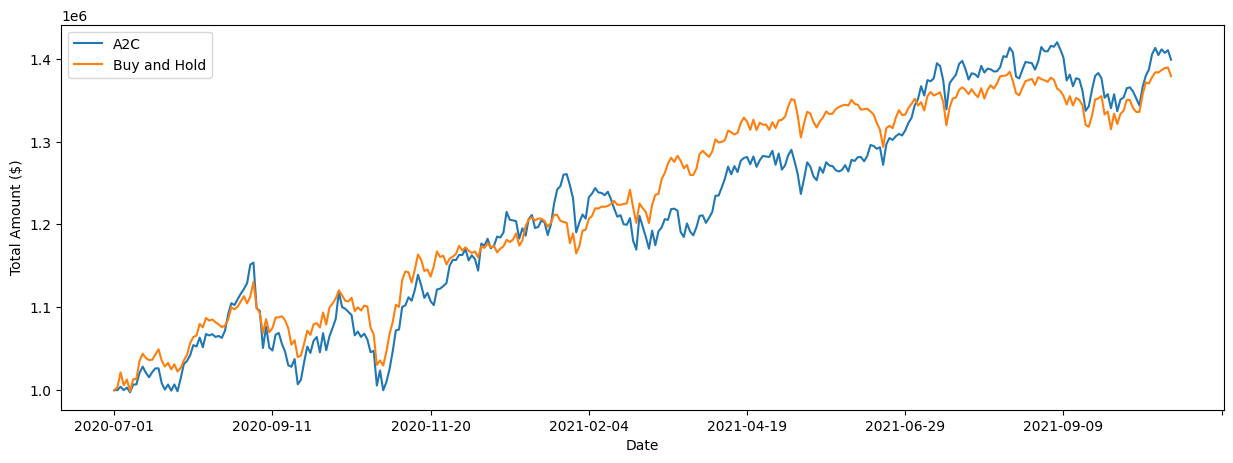

In [19]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
ax = result.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Total Amount ($)")


## Deep Deterministic Policy Gradient (DDPG)

In [20]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

# set up logger
tmp_path = RESULTS_DIR + '/ddpg'
new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [21]:
strt = time.time()
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=10000)
end = time.time()

---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 24       |
|    time_elapsed    | 479      |
|    total_timesteps | 11572    |
| train/             |          |
|    actor_loss      | -50.7    |
|    critic_loss     | 225      |
|    learning_rate   | 0.001    |
|    n_updates       | 8679     |
|    reward          | 6.582012 |
---------------------------------


In [22]:
print("DDPG Training Time:", end - strt)

DDPG Training Time: 590.5706379413605


In [23]:
trained_moedl = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [24]:
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_account_value_ddpg.to_csv("df_account_value_ddpg.csv")


result = pd.merge(df_result_ddpg, df_dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')
result.columns = ['DDPG', 'Buy and Hold']

result.head()

,DDPG,Buy and Hold
date,,
2020-07-01,1.000000e+06,1000000.000
2020-07-02,1.000562e+06,1003590.057
2020-07-06,1.006367e+06,1021451.744
2020-07-07,9.994152e+05,1006031.093
2020-07-08,1.006197e+06,1012912.780


Text(0, 0.5, 'Total Amount ($)')

<Figure size 1500x500 with 0 Axes>

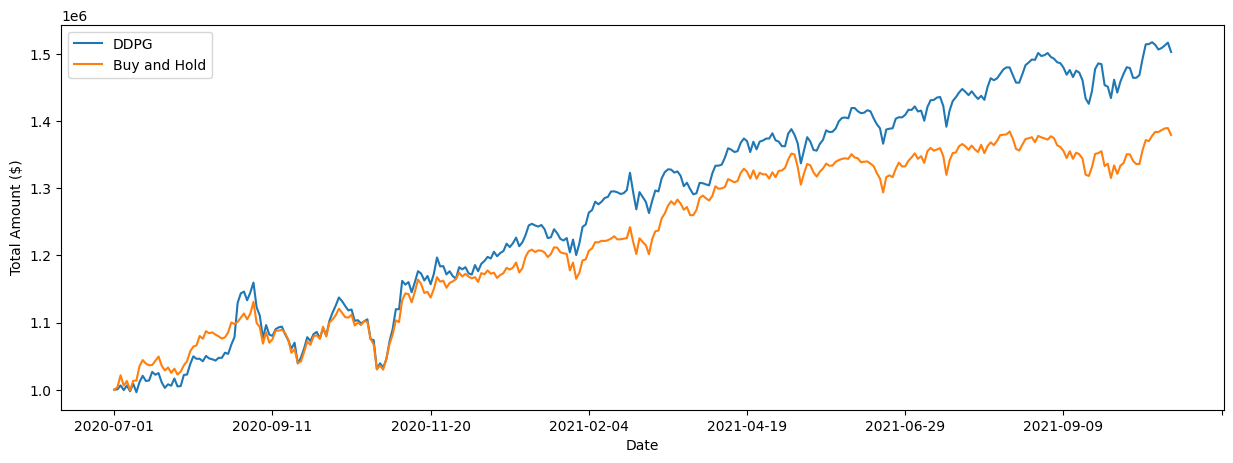

In [25]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
ax = result.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Total Amount ($)")

## Proximal Policy Optimization (PPO)

In [26]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)


# set up logger
tmp_path = RESULTS_DIR + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [27]:
strt = time.time()
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=10000)
end = time.time()

-----------------------------------
| time/              |            |
|    fps             | 73         |
|    iterations      | 1          |
|    time_elapsed    | 28         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.28029847 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 2           |
|    time_elapsed         | 56          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.021220092 |
|    clip_fraction        | 0.25        |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.0234     |
|    learning_rate        | 0.00025     |
|    loss                 | 9.86        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.022      |
|   

In [28]:
print("PPO Training Time:", end - strt)

PPO Training Time: 146.00216436386108


In [29]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [30]:
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_account_value_ppo.to_csv("df_account_value_ppo.csv")


result = pd.merge(df_result_ppo, df_dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')
result.columns = ['PPO', 'Buy and Hold']

result.head()

,PPO,Buy and Hold
date,,
2020-07-01,1.000000e+06,1000000.000
2020-07-02,1.000030e+06,1003590.057
2020-07-06,1.000305e+06,1021451.744
2020-07-07,9.998884e+05,1006031.093
2020-07-08,1.000104e+06,1012912.780


Text(0, 0.5, 'Total Amount ($)')

<Figure size 1500x500 with 0 Axes>

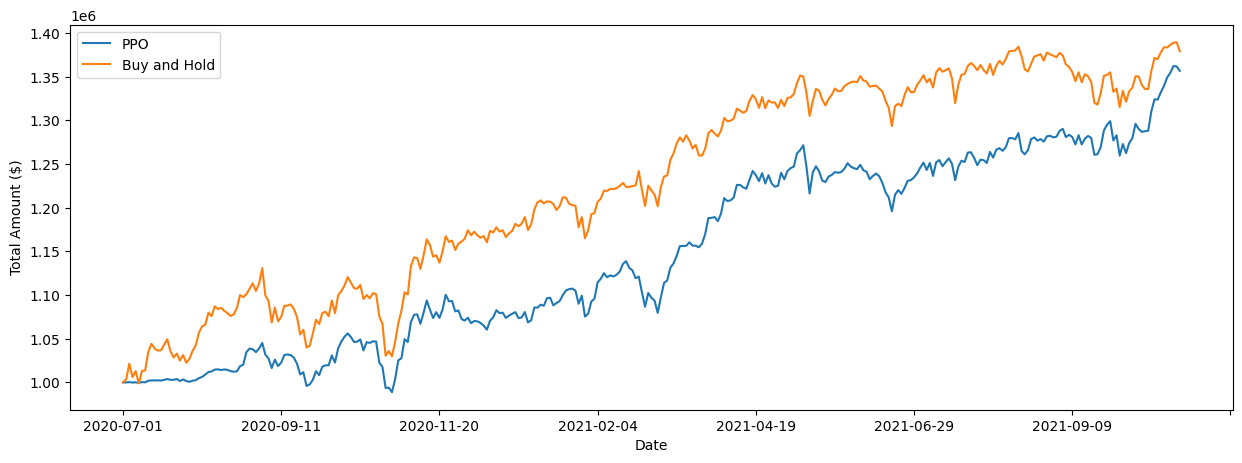

In [31]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
ax = result.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Total Amount ($)")

## Twin-Delayed Deep Deterministic Policy Gradient (TD3)

In [112]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

# set up logger
tmp_path = RESULTS_DIR + '/td3'
new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [102]:
strt = time.time()
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=10000)
end = time.time()

In [71]:
print("TD3 Training Time:", end - strt)

TD3 Training Time: 559.5030941963196


In [103]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [104]:
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_account_value_td3.to_csv("df_account_value_td3.csv")


result = pd.merge(df_result_td3, df_dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')
result.columns = ['TD3', 'Buy and Hold']

result.head()

,TD3,Buy and Hold
date,,
2020-07-01,1.000000e+06,1000000.000
2020-07-02,1.000147e+06,1003590.057
2020-07-06,1.003292e+06,1021451.744
2020-07-07,1.001064e+06,1006031.093
2020-07-08,1.003018e+06,1012912.780


Text(0, 0.5, 'Total Amount ($)')

<Figure size 1500x500 with 0 Axes>

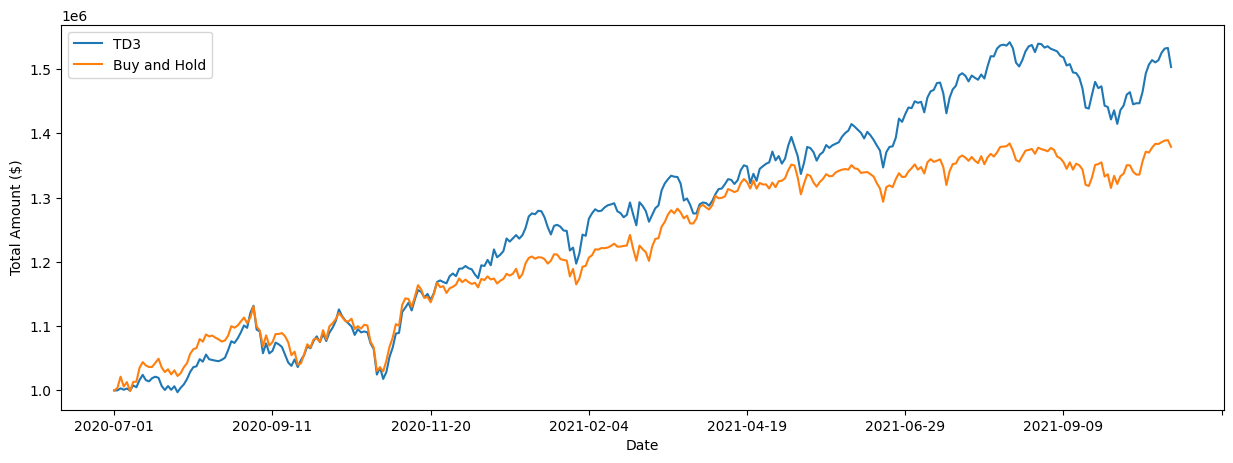

In [105]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
ax = result.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Total Amount ($)")

## Soft Actor-Critic (SAC)

In [38]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

# set up logger
tmp_path = RESULTS_DIR + '/sac'
new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [39]:
strt = time.time()
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=10000)
end = time.time()

day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 4361924.83
total_reward: 3361924.83
total_cost: 6590.54
total_trades: 33741
Sharpe: 0.771


In [40]:
print("SAC Training Time:", end - strt)

SAC Training Time: 507.50654339790344


In [41]:
trained_moedl = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [42]:
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_account_value_sac.to_csv("df_account_value_sac.csv")


result = pd.merge(df_result_sac, df_dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')
result.columns = ['SAC', 'Buy and Hold']

result.head()

,SAC,Buy and Hold
date,,
2020-07-01,1.000000e+06,1000000.000
2020-07-02,1.000063e+06,1003590.057
2020-07-06,1.000628e+06,1021451.744
2020-07-07,1.000154e+06,1006031.093
2020-07-08,1.000581e+06,1012912.780


Text(0, 0.5, 'Total Amount ($)')

<Figure size 1500x500 with 0 Axes>

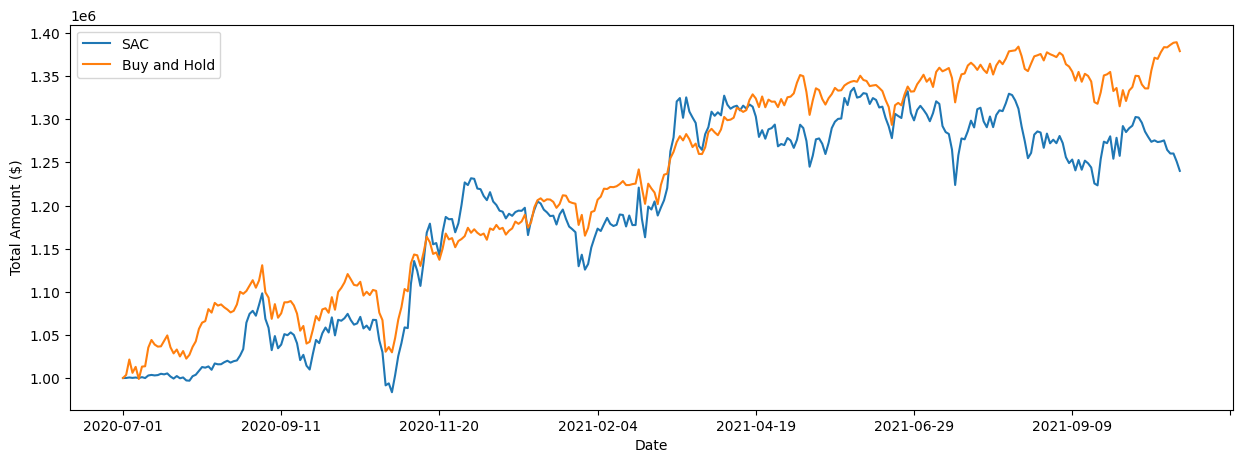

In [43]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
ax = result.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Total Amount ($)")

# Model Comparison

In [55]:
df_result_a2c.head()

,account_value
date,
2020-07-01,1.000000e+06
2020-07-02,1.000185e+06
2020-07-06,1.004186e+06
2020-07-07,1.000076e+06
2020-07-08,1.003081e+06


In [106]:
result = pd.DataFrame()
result = pd.merge(df_result_a2c, df_result_ddpg, how='outer', left_index=True, right_index=True)
result.columns = ['A2C', 'DDPG']
result['PPO'] = df_result_ppo['account_value']
result['TD3'] = df_result_td3['account_value']
result['SAC'] = df_result_sac['account_value']
result['Buy and Hold'] = df_dji['account_value']

result.head()

,A2C,DDPG,PPO,TD3,SAC,Buy and Hold
date,,,,,,
2020-07-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1000000.000
2020-07-02,1.000185e+06,1.000562e+06,1.000030e+06,1.000147e+06,1.000063e+06,1003590.057
2020-07-06,1.004186e+06,1.006367e+06,1.000305e+06,1.003292e+06,1.000628e+06,1021451.744
2020-07-07,1.000076e+06,9.994152e+05,9.998884e+05,1.001064e+06,1.000154e+06,1006031.093
2020-07-08,1.003081e+06,1.006197e+06,1.000104e+06,1.003018e+06,1.000581e+06,1012912.780


Text(0, 0.5, 'Total Amount ($)')

<Figure size 1500x500 with 0 Axes>

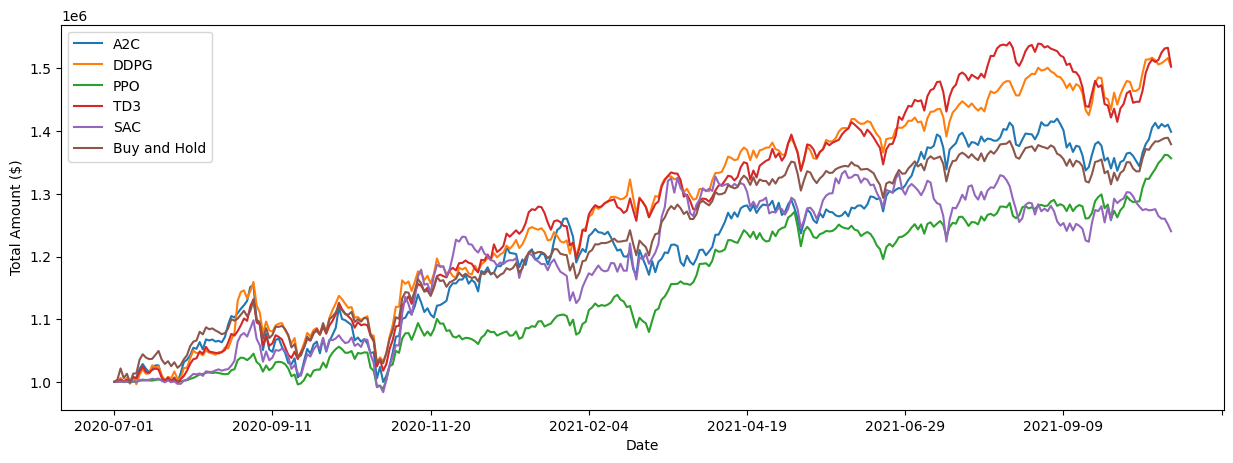

In [107]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
ax = result.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Total Amount ($)")

In [111]:
print("A2C Results")
print("Profit Earned:", df_result_a2c['account_value'][-1] - 1000000)
print("Total Return:", (df_result_a2c['account_value'][-1] - 1000000)/1000000 * 100)
print("\n")

print("DDPG Results")
print("Profit Earned:", df_result_ddpg['account_value'][-1] - 1000000)
print("Total Return:", (df_result_ddpg['account_value'][-1] - 1000000)/1000000 * 100)
print("\n")

print("PPO Results")
print("Profit Earned:", df_result_ppo['account_value'][-1] - 1000000)
print("Total Return:", (df_result_ppo['account_value'][-1] - 1000000)/1000000 * 100)
print("\n")

print("TD3 Results")
print("Profit Earned:", df_result_td3['account_value'][-1] - 1000000)
print("Total Return:", (df_result_td3['account_value'][-1] - 1000000)/1000000 * 100)
print("\n")

print("SAC Results")
print("Profit Earned:", df_result_sac['account_value'][-1] - 1000000)
print("Total Return:", (df_result_sac['account_value'][-1] - 1000000)/1000000 * 100)
print("\n")

print("Baseline Results")
print("Profit Earned:", df_dji['account_value'][-1] - 1000000)
print("Total Return:", (df_dji['account_value'][-1] - 1000000)/1000000 * 100)
print("\n")

A2C Results
Profit Earned: 398912.36351288226
Total Return: 39.89123635128823


DDPG Results
Profit Earned: 502619.6555349808
Total Return: 50.26196555349808


PPO Results
Profit Earned: 356668.85936466395
Total Return: 35.6668859364664


TD3 Results
Profit Earned: 503213.32174549834
Total Return: 50.32133217454984


SAC Results
Profit Earned: 240211.01336699887
Total Return: 24.02110133669989


Baseline Results
Profit Earned: 379084.17999999993
Total Return: 37.90841799999999


